# Generative modelling in deep learning

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

## GAN Part

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

>  
*   Wasserstein distance
*   Kullback–Leibler divergence 
*  Jensen–Shannon Divergence (variation of KL divergence, symmetric)
*  Statistical tests on the samples from the distibutions such as the Q-Q test, Pearson correlation coefficient and Kendall’s coefficient.



Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

> When using metrics that compare values sampled from the distributions, we need to have enough samples that represent well the distributions. Metrics on the probability distributions may involve some intractable integrals and expensive computations. 

In this work, we will focus on two of the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GANs) and Variational AutoEncoders (VAEs), in order to compare them and understand their strengths and weaknesses.

### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> We can expect N to be small as the basis for a low dimentional representation of incoming features.

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions. 
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> If the disciminator is perfect then D(x)=1 for all real samples and D(x)=0 for all generated samples, so $\mathcal{L}_D$ will be equal zero resulting in a vanishing gradient.

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

>  If we have a bad discriminator that labels all data points as real, then the generator who only has good feedback on the samples it generated will assume it is strong and will have no incentive to improve its performance.

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

In [ ]:
import torch
import torch.nn.functional as F
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

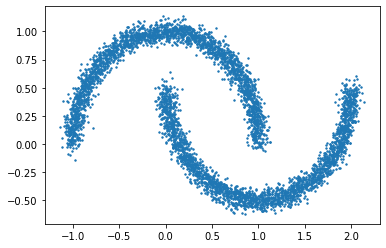

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [ ]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128, 2)

    def __call__(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = self.fc3(z)
        return z
    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)
    

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def __call__(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

step 0: discriminator: 1.343e+00, generator: 7.432e-01


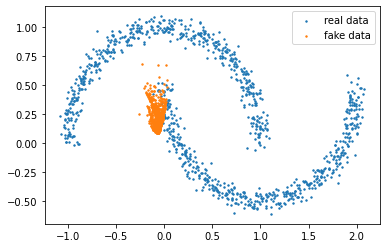

step 1000: discriminator: 1.378e+00, generator: 7.198e-01


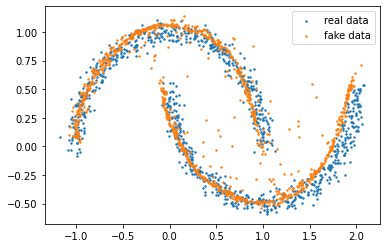

step 2000: discriminator: 1.381e+00, generator: 6.938e-01


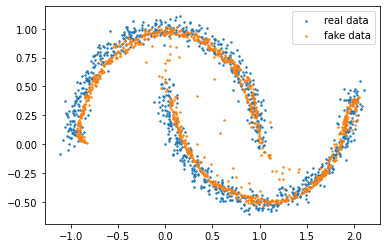

step 3000: discriminator: 1.378e+00, generator: 7.014e-01


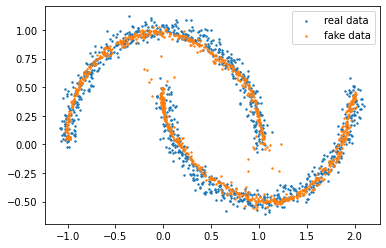

step 4000: discriminator: 1.391e+00, generator: 6.939e-01


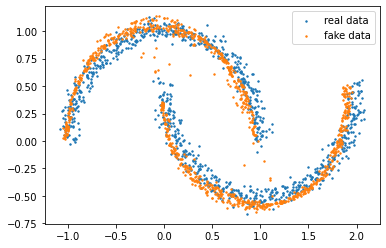

step 5000: discriminator: 1.390e+00, generator: 7.004e-01


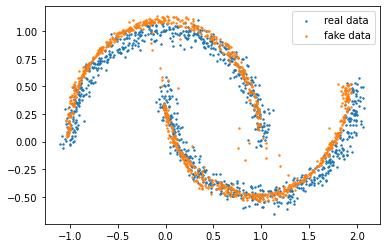

step 6000: discriminator: 1.388e+00, generator: 6.952e-01


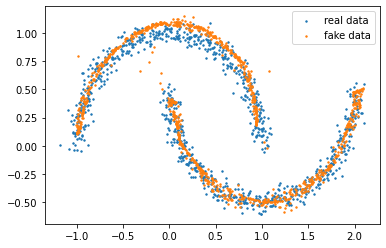

step 7000: discriminator: 1.386e+00, generator: 6.929e-01


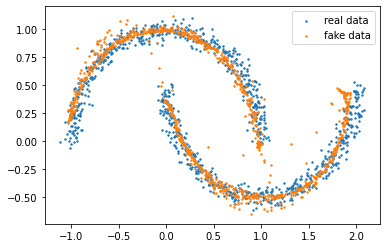

step 8000: discriminator: 1.386e+00, generator: 6.878e-01


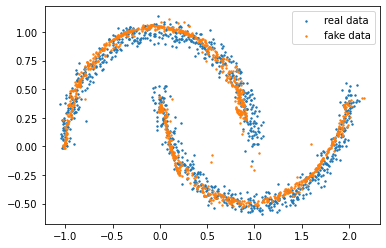

step 9000: discriminator: 1.388e+00, generator: 6.930e-01


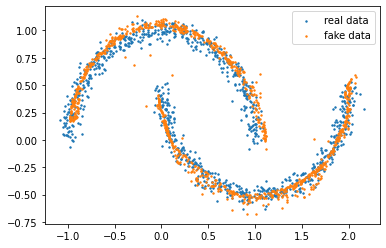

step 10000: discriminator: 1.387e+00, generator: 6.938e-01


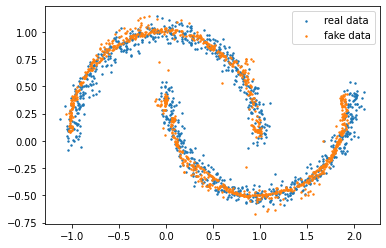

step 11000: discriminator: 1.382e+00, generator: 6.992e-01


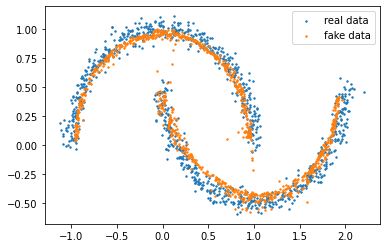

step 12000: discriminator: 1.384e+00, generator: 7.040e-01


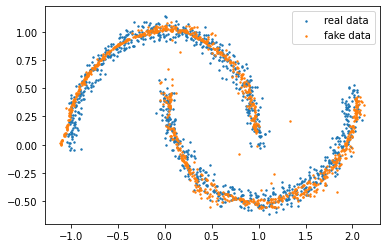

step 13000: discriminator: 1.379e+00, generator: 7.256e-01


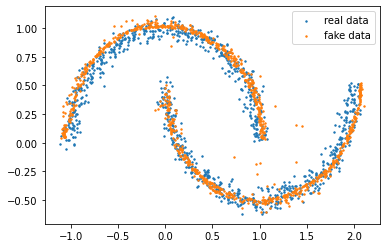

step 14000: discriminator: 1.377e+00, generator: 7.094e-01


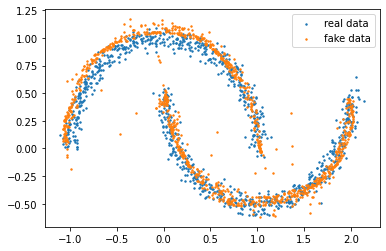

step 15000: discriminator: 1.384e+00, generator: 6.953e-01


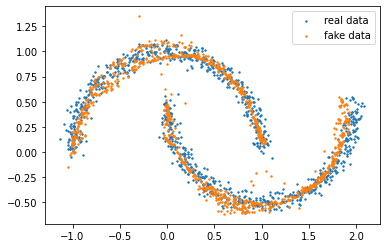

step 16000: discriminator: 1.377e+00, generator: 7.129e-01


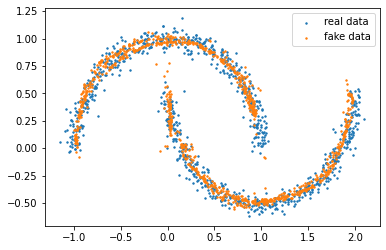

step 17000: discriminator: 1.374e+00, generator: 6.893e-01


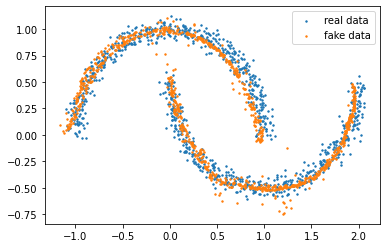

step 18000: discriminator: 1.372e+00, generator: 7.018e-01


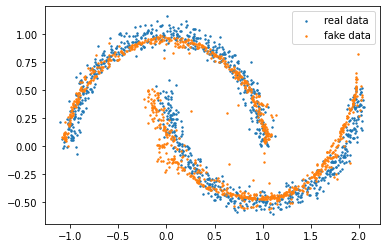

step 19000: discriminator: 1.375e+00, generator: 7.062e-01


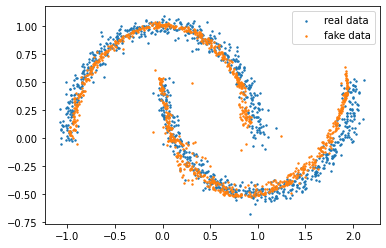

step 20000: discriminator: 1.368e+00, generator: 6.911e-01


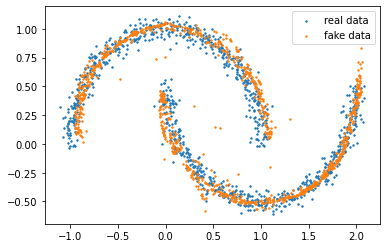

In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 3
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

##testing: 
criterion_disc = torch.nn.BCEWithLogitsLoss()
true_label = torch.ones((BATCHLEN, 1))
fake_label = torch.zeros((BATCHLEN, 1))
##

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        #
        ##testing
        disc_true = discriminator(real_batch)
        disc_fake = discriminator(fake_batch)
        disc_loss = criterion_disc(disc_true, true_label) + criterion_disc(disc_fake, fake_label)
        ##
        disc_loss.backward()
        optim_disc.step()

    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    #
    ##testing
    disc_fake = discriminator(fake_batch)
    # gen_loss = log(D(G(z)))
    gen_loss = criterion_disc(disc_fake, true_label)
    ##

    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> At the beginning the generator is poor and the discriminator identifies easily the generated images leading to D(x)=0 for every generated x and $\mathcal{L}_G$ equal to zero, this creates a vanishing gradient problem.

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

> The depth and width of the generator and discriminator are important, with one layer, we get fake samples that are very differnet from the real samples and the model deosn't converge. When adding few layers along with a ReLU activation to account for the non linearity of the data, we start to get better results. 
> 
>   When we use a wide generator with 2 layers and 128 neurons on each layer, along with a discriminator with two layers and 32 neurons on each, we start to get fake samples similar to the real samples but there are some noisy data points. However, making the discriminator wider with 64 neurons on each of its two layers instead of 32 improves the performance significantly and we get good results. A deeper disciminator with 3 layers and 64, 32 and 32 neurons per layer is just as good.
> 
> When we increase `TRAIN_RATIO` from 1 to 3, we get good results earlier in the training, thus speeding up the convergence.

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

## Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

From the definition of the KL divergence, 

$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right] = \int_x  log \left(\frac{p_D(x)}{p_\theta(x)}\right)p_D(x)dx=
\underbrace{\mathbb{E}_{p_D}\left[ log(p_D) \right]}_{independant~of~\theta}-\mathbb{E}_{p_D}\left[ log(p_\theta) \right]$$

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

> (Write your answer here, what will be the influence on data generation by VAE)

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

For the sake of clarity let us denote $\Sigma_{\phi} = Diag(\sigma_\phi^2(x)).$

$D_{KL}(q_\phi(z | x) \| p(z))= \int_z  log \left(\frac{q_\phi(z | x)}{p(z)}\right) q_\phi(z | x) dz = \mathbb{E}_{q}\left[ log(\frac{q}{p}) \right]= \mathbb{E}_{q}\left[ log \left(\frac{|Σ_{\phi}|^{-\frac{1}{2}}\times exp \left(-\frac{1}{2}[z-\mu_\phi(x)]^{T} Σ_\phi^{-1}[z-\mu_\phi(x)] \right)  }{exp \left(-\frac{1}{2}z^{T}Iz \right)}  \right) \right] = 
\mathbb{E}_{q}\left[ -\frac{1}{2}log|Σ_{\phi}|-\frac{1}{2}[z-\mu_\phi(x)]^{T} Σ_\phi^{-1}[z-\mu_\phi(x)] + \frac{1}{2}z^{T}Iz \right] = -\frac{1}{2}log|Σ_{\phi}|+ \frac{1}{2} \mathbb{E}_{q}\left[-[z-\mu_\phi(x)]^{T} Σ_\phi^{-1}[z-\mu_\phi(x)] + z^{T}Iz \right].$

Then we can write: 

$[z-\mu_\phi(x)]^{T} Σ_\phi^{-1}[z-\mu_\phi(x)] = Tr \left(  [z-\mu_\phi(x)]^{T} Σ_\phi^{-1}[z-\mu_\phi(x)]\right) = Tr \left(  [z-\mu_\phi(x)] [z-\mu_\phi(x)]^{T} Σ_\phi^{-1} \right).$

By linearity of the expectation: 

$\mathbb{E}_{q}\left[ Tr \left(  [z-\mu_\phi(x)] [z-\mu_\phi(x)]^{T} Σ_\phi^{-1} \right) \right] = Tr \left( \mathbb{E}_{q}\left[ [z-\mu_\phi(x)] [z-\mu_\phi(x)]^{T} Σ_\phi^{-1} \right] \right) = Tr \left( Σ_\phiΣ_\phi^{-1} \right)= N$ 

where $N$ is the latent dimension. 

Finally, we have to compute $\mathbb{E}_{q}\left[ z^{T}Iz \right]$. We make use of the same trick to write $\mathbb{E}_{q}\left[ z^{T}Iz \right] = \mathbb{E}_{q}\left[ Tr(Iz z^{T}) \right]=Tr \left(I\mathbb{E}_{q}\left[zz^{T} \right] \right) = Tr \left(I[\Sigma_{\phi}+ \mu_\phi(x) \mu_\phi(x)^{T}]  \right) = Tr \left(I\Sigma_{\phi}  \right) + Tr \left( \mu_\phi(x)^{T}I\mu_\phi(x)\right) = Tr \left(\Sigma_{\phi}  \right) + \mu_\phi(x)^{T}\mu_\phi(x)$

Putting all terms together,

$D_{KL}(q_\phi(z | x) \| p(z))= \frac{1}{2}\left[-log|Σ_{\phi}|-N+Tr \left(\Sigma_{\phi}  \right) + \mu_\phi(x)^{T}\mu_\phi(x) \right] = \frac{1}{2} \sum_{j=1}^{N}\left[-log \left(\sigma_{\phi, j}^{2}(x)\right)-1+\sigma_{\phi, j}^{2}(x)+\mu_{\phi, j}^{2}(x)\right]$

We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

$p_\theta(x | z) \propto |Σ_{\theta}|^{-\frac{1}{2}}\times exp \left(-\frac{1}{2}[x-\mu_\theta(z)]^{T} Σ_\theta^{-1}[x-\mu_\theta(z) ] \right)$

Thus:


$-\log p_\theta(x | z) = -log \left[|Σ_{\theta}|^{-\frac{1}{2}}\times exp \left(-\frac{1}{2}[x-\mu_\theta(z)]^{T} Σ_\theta^{-1}[x-\mu_\theta(z)] \right) \right]= \frac{1}{2}log|Σ_{\theta}|+\frac{1}{2}[x-\mu_\theta(z)]^{T} Σ_\theta^{-1}[x-\mu_\theta(z)] + constant$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10

# Define the generator
class Encoder_D(nn.Module):
    def __init__(self, hidden_layers=2, hidden_width=30):
        super().__init__()
        self.fc_input = nn.Linear(2, hidden_width)
        self.fc_hidden = nn.ModuleList()
        for layer in range(hidden_layers):
          self.fc_hidden.append(nn.Linear(hidden_width,hidden_width)) 
        self.fc_mu = nn.Linear(hidden_width, LATENT_N)
        self.fc_logvar = nn.Linear(hidden_width, LATENT_N)
        
    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        x = F.relu(self.fc_input(x))
        for layer in self.fc_hidden: 
          x = F.relu(layer(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)
    

# Define the discriminator
class Decoder_D(nn.Module):
    def __init__(self,hidden_layers=2,hidden_width=30, hardcode_var=None):
        super().__init__()
        self.var = hardcode_var
        self.fc_input = nn.Linear(LATENT_N, hidden_width)
        self.fc_hidden = nn.ModuleList()
        for layer in range(hidden_layers):
          self.fc_hidden.append(nn.Linear(hidden_width,hidden_width))
        self.fc_mu = nn.Linear(hidden_width, 2)
        if hardcode_var == None:
          self.fc_logvar = nn.Linear(hidden_width, 2)
    
    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        z = F.relu(self.fc_input(z))
        for layer in self.fc_hidden: 
          z = F.relu(layer(z))
        mu = self.fc_mu(z)
        if self.var == None:
          logvar = self.fc_logvar(z)
        else: 
          logvar = self.var*torch.ones_like(mu)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$. 

In [ ]:
from operator import matmul
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128


def VAE_training(encoder = Encoder_D(6,16),decoder = Decoder_D(6,16), plot=False):

    optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
    optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

    loss = []
    for i in range(N_ITER):
      encoder.zero_grad()
      decoder.zero_grad()

      #Inputs:
      x = generate_batch(BATCHLEN)
      # x is of shape (BATCHLEN,2)
    
      #Encoder outputs:
      enc_mu, enc_logvar = encoder(x)
      #Vectors of shape (BATCHLEN,LATENT_N)

    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    #loss_kl = 0

    #First sum over the latent dimension, then average over the batch size:
    #loss_kl = torch.mean(- 0.5 * LATENT_N + 0.5 * torch.sum(enc_mu ** 2 + torch.exp(enc_logvar)- enc_logvar, dim = 1)) #, dim = 0)
    #substract the - 0.5 * LATENT_N part, which is constant....
      #loss_kl = torch.mean(0.5 * torch.sum(enc_mu ** 2 + torch.exp(enc_logvar)- enc_logvar, dim = 1))
      enc_var = torch.exp(0.5*enc_logvar) ** 2 
      loss_kl = 0.5 * torch.sum(enc_mu ** 2 + enc_var - enc_logvar, dim=1) 
      loss_kl = loss_kl.mean()

    #
    # SAMPLE z FROM q(z|x) HERE
    #
      #z = torch.normal(enc_mu,torch.exp(0.5*enc_logvar))
      z = enc_mu + torch.exp(0.5*enc_logvar) * torch.randn((BATCHLEN,LATENT_N)) 
    #Tensor of shape (BATCHLEN,LATENT_N)
    
    #Decoder output:
      dec_mu, dec_logvar = decoder(z)
    #tensors of shape (BATCHLEN,2)

    #Hard-coding of dec_var
    #dec_logvar = 1e-4*torch.ones(BATCHLEN,2)

    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
      log_p = 0.5*torch.sum((x - dec_mu)**2/torch.exp(dec_logvar),dim=1)+ 0.5*(torch.sum(dec_logvar,dim=1))
    
    #print(dec_logvar.shape)

    #Approx of the expectation over z:
      loss_rec = torch.mean(log_p) 
    #loss_rec = 0
      alpha=0.7
      total_loss = alpha*loss_kl + loss_rec
      total_loss.backward()
      loss.append(float(total_loss))
      optim_enc.step()
      optim_dec.step()
      if plot: 
        if i%10000 == 0:
            print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
            real_batch = generate_batch(1024)
            rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
            fake_batch = decoder.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.legend()
            plt.show()
    return loss

step 0: KL: 5.168e+00, rec: 6.874e-01


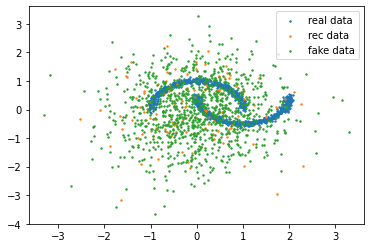

step 10000: KL: 7.968e+00, rec: -1.316e+00


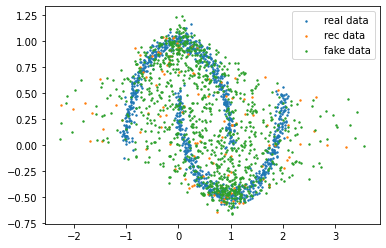

step 20000: KL: 8.160e+00, rec: -2.950e+00


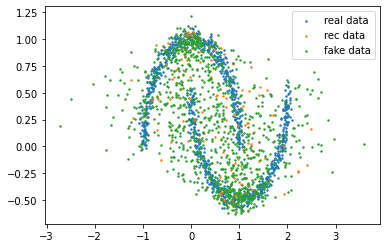

step 30000: KL: 8.230e+00, rec: -3.432e+00


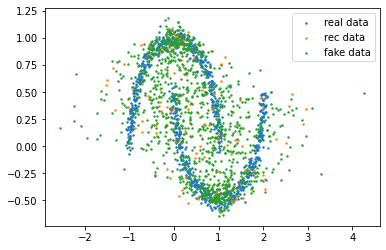

step 40000: KL: 8.374e+00, rec: -3.692e+00


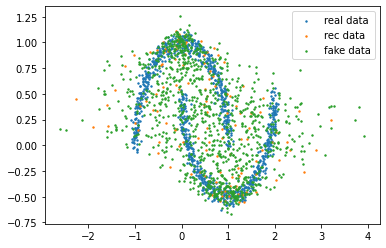

step 0: KL: 5.107e+00, rec: 8.296e-01


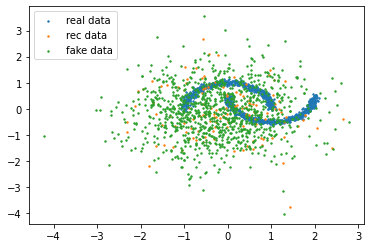

step 10000: KL: 5.080e+00, rec: 4.537e-01


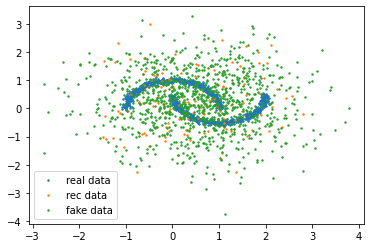

step 20000: KL: 5.087e+00, rec: 4.862e-01


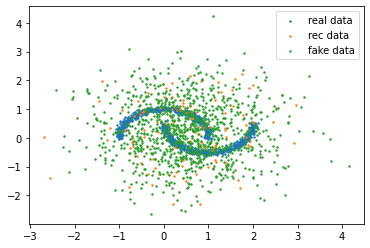

step 30000: KL: 5.076e+00, rec: 4.418e-01


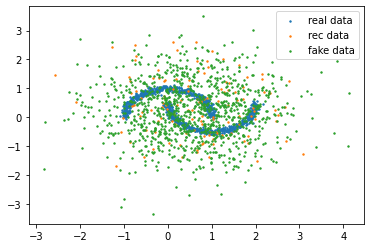

step 40000: KL: 5.080e+00, rec: 4.526e-01


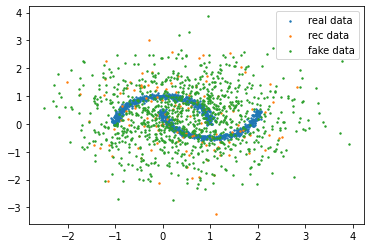

In [ ]:
h,s=2,30
print("----------WITH DEC_VAR ESTIMATED----------------")
loss_var=VAE_training(encoder = Encoder_D(h,s),decoder = Decoder_D(h,s), plot=True)
print("----------WITH DEC_VAR HARDCODED----------------")
loss_var_hard=VAE_training(encoder = Encoder_D(h,s),decoder = Decoder_D(h,s,1e-4), plot=True)

<Figure size 432x288 with 0 Axes>

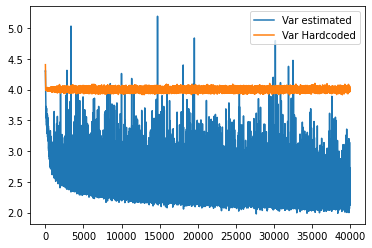

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(loss_var, label='Var estimated')
plt.plot(loss_var_hard, label='Var Hardcoded')
plt.legend()
plt.figure()

### Using reparametrization trick (change std in loss_kl)

step 0: KL: 5.038e+00, rec: 7.121e-01


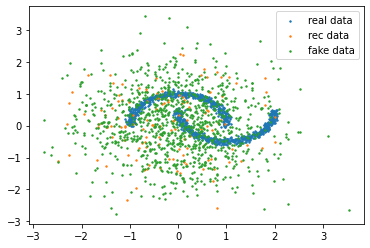

step 1000: KL: 6.731e+00, rec: -7.241e-01


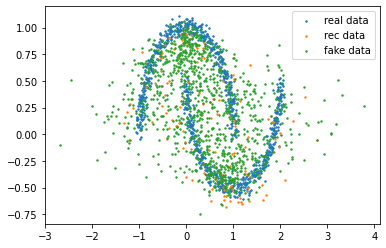

step 2000: KL: 6.809e+00, rec: -2.024e+00


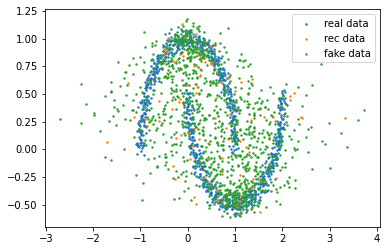

step 3000: KL: 7.006e+00, rec: -2.143e+00


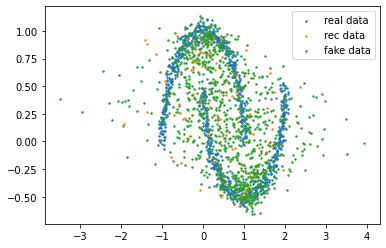

step 4000: KL: 7.206e+00, rec: -2.256e+00


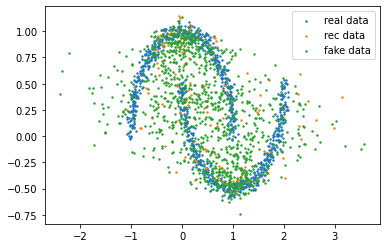

step 5000: KL: 7.322e+00, rec: -2.563e+00


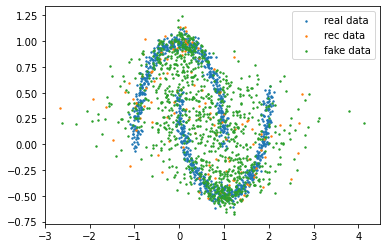

step 6000: KL: 7.307e+00, rec: -2.609e+00


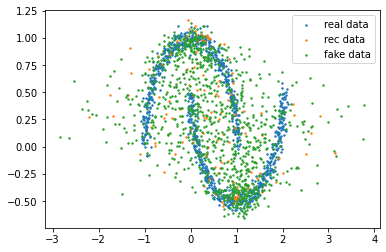

step 7000: KL: 7.345e+00, rec: -2.692e+00


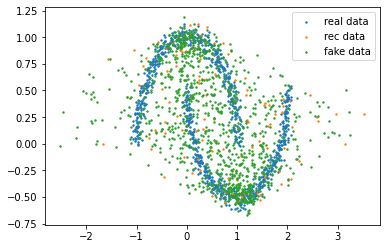

step 8000: KL: 7.547e+00, rec: -2.837e+00


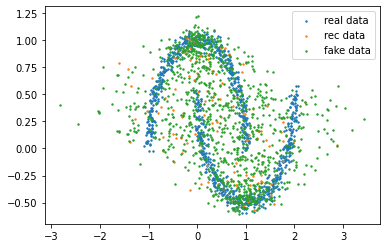

step 9000: KL: 7.584e+00, rec: -2.985e+00


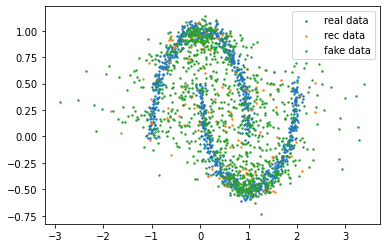

step 10000: KL: 7.766e+00, rec: -1.937e+00


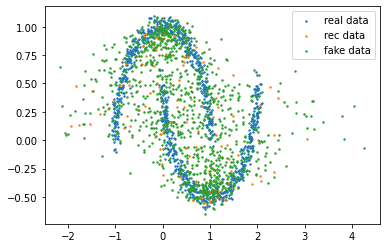

step 11000: KL: 7.698e+00, rec: -2.807e+00


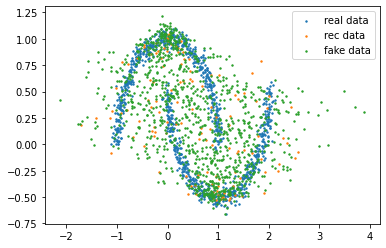

step 12000: KL: 7.787e+00, rec: -3.085e+00


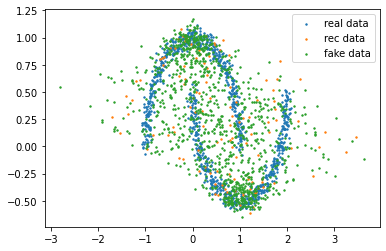

step 13000: KL: 7.761e+00, rec: -3.093e+00


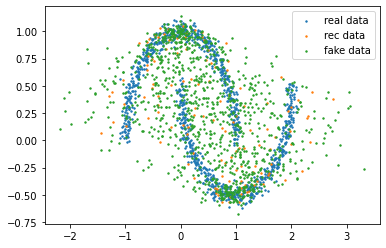

step 14000: KL: 7.816e+00, rec: -3.122e+00


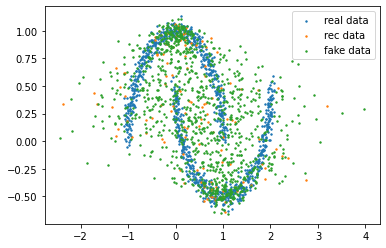

step 15000: KL: 7.817e+00, rec: -3.136e+00


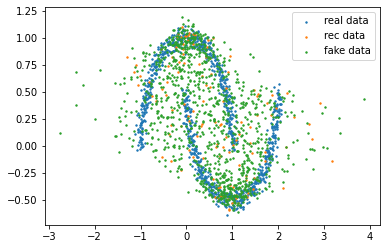

step 16000: KL: 7.805e+00, rec: -3.119e+00


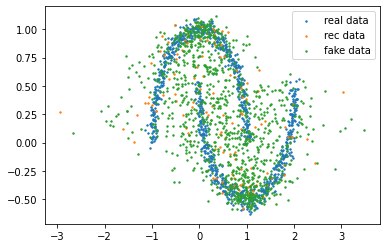

step 17000: KL: 7.998e+00, rec: -3.225e+00


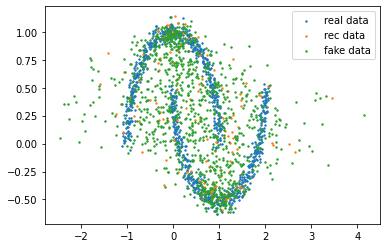

step 18000: KL: 7.933e+00, rec: -3.233e+00


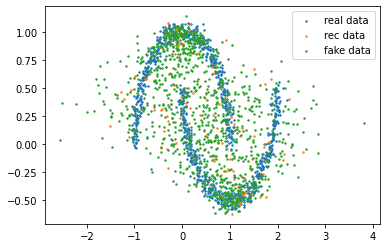

step 19000: KL: 8.028e+00, rec: -3.191e+00


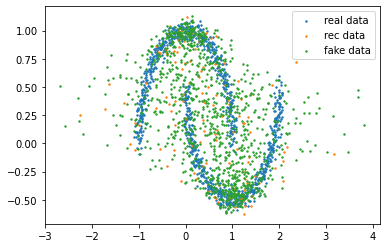

step 20000: KL: 8.091e+00, rec: -3.157e+00


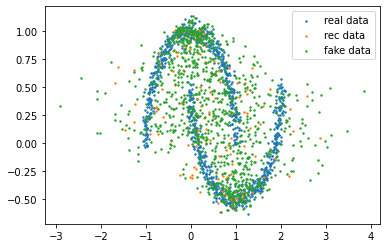

step 21000: KL: 8.024e+00, rec: -3.369e+00


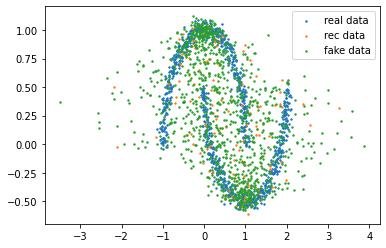

step 22000: KL: 8.097e+00, rec: -3.333e+00


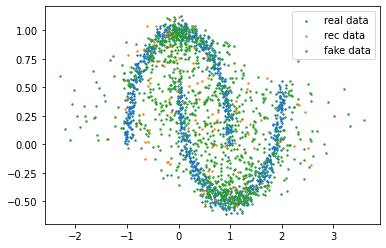

step 23000: KL: 8.065e+00, rec: -3.415e+00


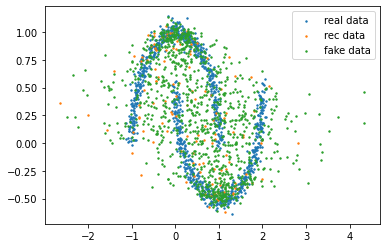

step 24000: KL: 8.108e+00, rec: -3.359e+00


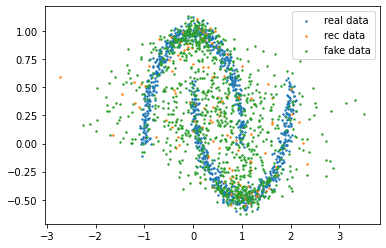

step 25000: KL: 8.166e+00, rec: -2.771e+00


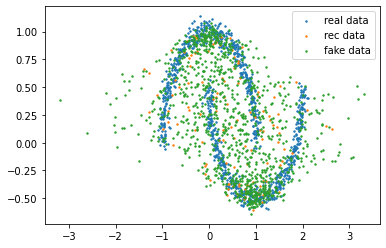

step 26000: KL: 8.056e+00, rec: -3.317e+00


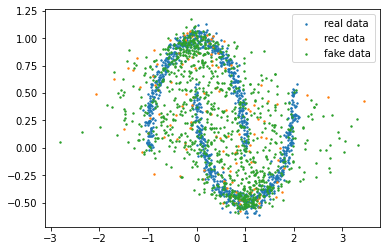

step 27000: KL: 8.180e+00, rec: -3.378e+00


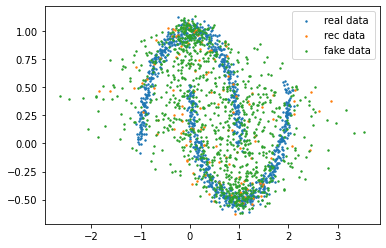

step 28000: KL: 8.171e+00, rec: -3.463e+00


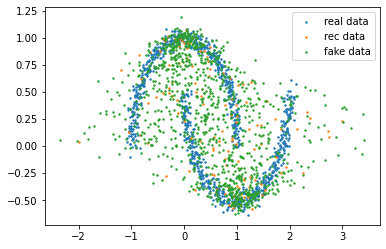

step 29000: KL: 8.187e+00, rec: -3.414e+00


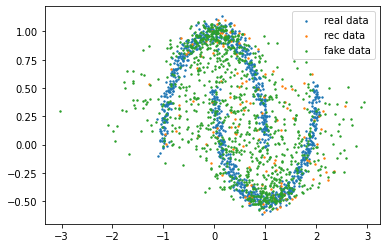

step 30000: KL: 8.159e+00, rec: -2.985e+00


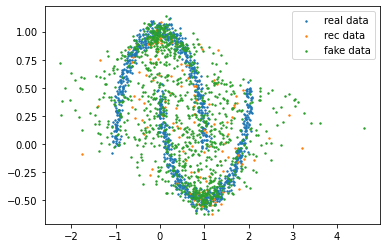

step 31000: KL: 8.140e+00, rec: -3.395e+00


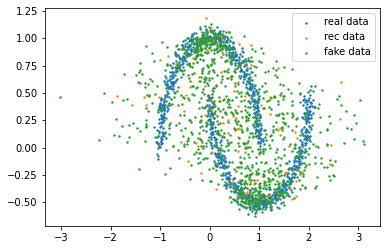

step 32000: KL: 8.226e+00, rec: -3.494e+00


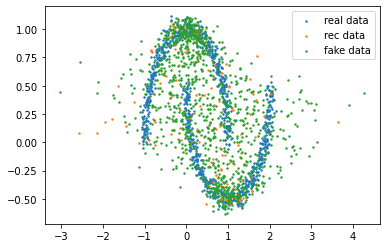

step 33000: KL: 8.250e+00, rec: -3.640e+00


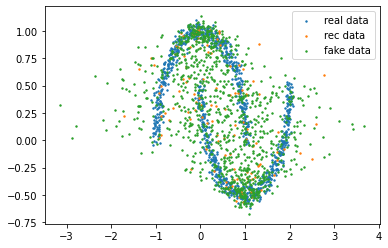

step 34000: KL: 8.299e+00, rec: -3.394e+00


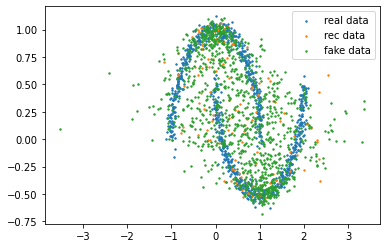

step 35000: KL: 8.224e+00, rec: -3.476e+00


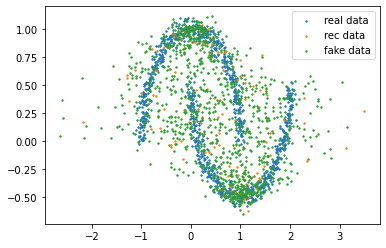

step 36000: KL: 8.349e+00, rec: -3.340e+00


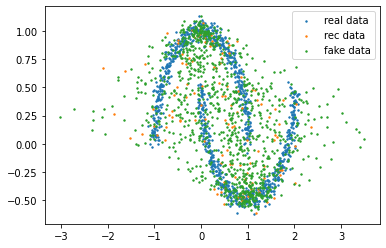

step 37000: KL: 8.304e+00, rec: -3.580e+00


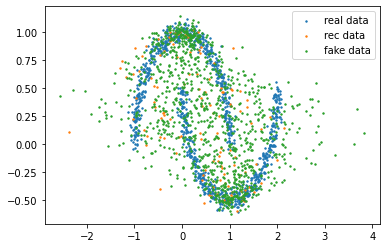

step 38000: KL: 8.275e+00, rec: -3.634e+00


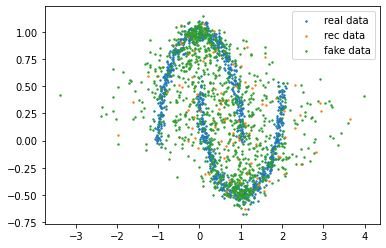

step 39000: KL: 8.358e+00, rec: -3.495e+00


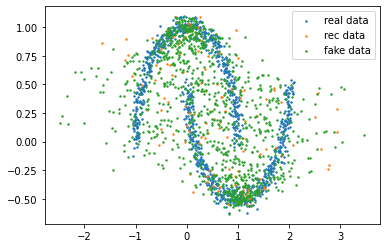

step 40000: KL: 8.231e+00, rec: -3.643e+00


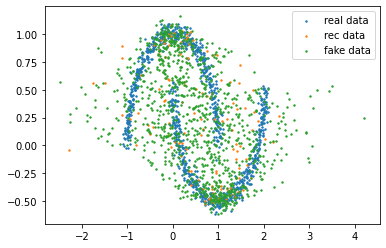

In [ ]:
from operator import matmul
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder_D(hidden_layers=3, hidden_width=100)
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder_D(hidden_layers=3, hidden_width=100)
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

loss = []


for i in range(N_ITER):
  encoder.zero_grad()
  decoder.zero_grad()

  #Inputs:
  x = generate_batch(BATCHLEN)
  # x is of shape (BATCHLEN,2)

  #Encoder outputs:
  enc_mu, enc_logvar = encoder(x)
  #Vectors of shape (BATCHLEN,LATENT_N)

  # COMPUTE THE KL PART OF THE LOSS HERE
  #
  #loss_kl = 0

  #First sum over the latent dimension, then average over the batch size
  enc_var = torch.exp(0.5*enc_logvar) ** 2 
  loss_kl = 0.5 * torch.sum(enc_mu ** 2 + enc_var- enc_logvar, dim=1) 
  loss_kl = loss_kl.mean()

  #
  # SAMPLE z FROM q(z|x) HERE
  #
  #z = torch.normal(enc_mu,torch.exp(0.5*enc_logvar))
  z = enc_mu + torch.exp(0.5*enc_logvar) * torch.randn((BATCHLEN,LATENT_N)) 
  #Tensor of shape (BATCHLEN,LATENT_N)

  #Decoder output:
  dec_mu, dec_logvar = decoder(z)
  #tensors of shape (BATCHLEN,2)

  #Hard-coding of dec_var
  #dec_logvar = 1e-3*torch.ones(BATCHLEN,2)

  # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
  #
  #print((x - dec_mu).shape,torch.exp(0.5*dec_logvar).shape)

  log_p = 0.5*torch.sum((x - dec_mu)**2/torch.exp(dec_logvar),dim=1)+ 0.5*(torch.sum(dec_logvar,dim=1))
  #was div 0.5*torch.exp(-dec_logvar)

  #print(dec_logvar.shape)

  #Approx of the expectation over z:
  loss_rec = torch.mean(log_p) 
  #loss_rec = 0
  total_loss = 0.7*loss_kl + loss_rec
  total_loss.backward()
  loss.append(float(total_loss))
  optim_enc.step()
  optim_dec.step()
  if i%1000 == 0:
      print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
    # plot the result
      real_batch = generate_batch(1024)
      rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
      fake_batch = decoder.generate(1024).detach()
      plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
      plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
      plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
      plt.legend()
      plt.show()

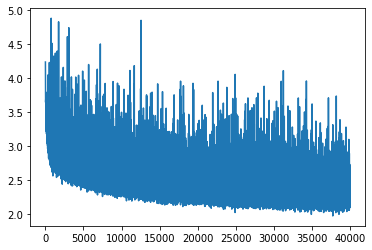

In [ ]:
plt.plot(loss)

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

> (Write your answer here, observe the plots)

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

In [ ]:
h,s=2,15
loss_1=VAE_training(encoder = Encoder_D(h,s),decoder = Decoder_D(h,s), plot=False)
loss_2=VAE_training(encoder = Encoder_D(h,2*s),decoder = Decoder_D(h,2*s), plot=False)
loss_3=VAE_training(encoder = Encoder_D(2*h,s),decoder = Decoder_D(2*h,s), plot=False)
loss_4=VAE_training(encoder = Encoder_D(2*h,2*s),decoder = Decoder_D(2*h,2*s), plot=False)
loss_5=VAE_training(encoder = Encoder_D(3*h,s),decoder = Decoder_D(3*h,s), plot=False)
loss_6=VAE_training(encoder = Encoder_D(3*h,3*s),decoder = Decoder_D(3*h,3*s), plot=False)
loss_7=VAE_training(encoder = Encoder_D(h,3*s),decoder = Decoder_D(h,3*s), plot=False)

<Figure size 576x432 with 0 Axes>

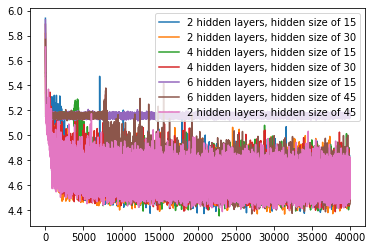

<Figure size 576x432 with 0 Axes>

In [ ]:
plt.figure(figsize=(8,6))

plt.plot(loss_1, label='2 hidden layers, hidden size of 15')
plt.plot(loss_2, label='2 hidden layers, hidden size of 30')
plt.plot(loss_3, label='4 hidden layers, hidden size of 15')
plt.plot(loss_4, label='4 hidden layers, hidden size of 30')
plt.plot(loss_5, label='6 hidden layers, hidden size of 15')
plt.plot(loss_6, label='6 hidden layers, hidden size of 45')
plt.plot(loss_7, label='2 hidden layers, hidden size of 45')

plt.legend()

> (Write your answer here)

## Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$. 
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**


Let's consider the change of variable $z → f(z)$ in $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz$

We get: 
$$\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz =  \int_{z\sim p_\mathcal{N}} g(z) |J_f(z)| dz$$

Thus:

$$ \int_{z\sim p_\mathcal{N}} g(z) |J_f(z)| dz = \int_{x\sim p_{G}} g(x) dx$$

This being true for all $g$, we have: 
$$
p_X(x)=p_Z(z) |J_f|
$$
And by applying the log, it comes that:

$$
\log(p_X(x))=\log(p_Z(z))+\log  |J_f|
$$


Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

$$KL(p_D || P_G) = \int P_D(x) (log P_D(x) - log P_G(x))$$
$$KL(p_D || P_G) = \int P_D(x) (log P_D(x) - log P_Z(z) - log|J_f|)$$


Thus, as a loss, to minimize the part in $z$ of the Kullback Leibler divergence expression we can take 
$$L = - \frac{1}{N} \sum (log P_G(z_i) + |J_f(z_i)|)$$


A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

Given the image $y$ of $x$ by the previous function.

* We can retrieve directly $x_{1:d} = y_{1:d}$

* And now that we know $x_{1:d}$, we have that $x_{d+1:D} = (x_{d+1:D} - t(x_{1:d})) \odot (1/exp(s(x_{1:d}))$ , where $(1/exp(s(x_{1:d}))$ is the termwise inverse of $exp(s(x_{1:d}))$ (non null thanks to the exponential).

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

Let's note $f$ the mapping and $J$ its jacobian.
Let's observe the form of |J|:

$\forall i \in [1..d]$, we have that: 
* $\frac{\partial f}{\partial x_i} = 1$ 
* $\forall j \neq i$, $\frac{\partial f}{\partial x_j} = 0$


$\forall i \in [d+1..D]$, we have that: 
* $\frac{\partial f}{\partial x_i} = exp(s(x_{1:d})_i)$    
* $\forall j \neq i$, $\frac{\partial f}{\partial x_j}$ only depends on elements of $x_{1:d}$.

Thus, we get that J is of the form 
$$\begin{pmatrix}
A & 0\\
C & D
\end{pmatrix}$$

Thus: $$|J| = |A| \times |D|$$

With $A$ and $D$ diagonal matrices of coefficients $exp(s(x_{1:d})_i)$ (see derivatives just above)

In conclusion:

$$|J| = \prod_i exp(s(x_{1:d})_i)  = exp(\sum_i exp(s(x_{1:d})_i) )$$


**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask):
        super().__init__()
        ### define here variables to use in f and s ###

        print(input_size, output_size, hidden_size)

        
        self.s_layers = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, output_size),
          nn.Tanh()
        )

        self.f_layers = nn.Sequential(
          nn.Linear(input_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, hidden_size),
          nn.ReLU(),
          nn.Linear(hidden_size, output_size),
          nn.Tanh()
        )

        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        # return x_m
        return self.s_layers(x_m)

        
    def tfun(self, x_m):
        # return x_m
        return self.f_layers(x_m)

        
    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        print("....................... YOOOO")
        print(self.mask.shape)


        x_m = y * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        out = x_m + (1- self.mask)*((y - t_out)/torch.exp(s_out))

        return out

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [ ]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [ ]:
from torch import distributions # optim, 
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

2 2 256
2 2 256
2 2 256
2 2 256
2 2 256
2 2 256
2 2 256
2 2 256


Train Epoch: 1 [0/50000 (0%)]	Loss: 0.022727
Train Epoch: 1 [6400/50000 (13%)]	Loss: -0.036798
Train Epoch: 1 [12800/50000 (26%)]	Loss: -0.048331
Train Epoch: 1 [19200/50000 (38%)]	Loss: -0.051014
Train Epoch: 1 [25600/50000 (51%)]	Loss: -0.052669
Train Epoch: 1 [32000/50000 (64%)]	Loss: -0.054262
Train Epoch: 1 [38400/50000 (77%)]	Loss: -0.053477
Train Epoch: 1 [44800/50000 (90%)]	Loss: -0.055178
====> Epoch: 1 Average train loss: -0.0469


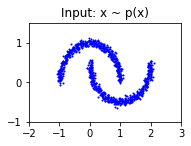

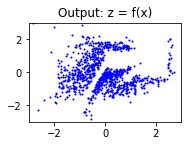

====> Test loss: -0.0569
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])


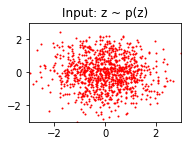

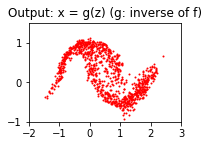

Train Epoch: 2 [0/50000 (0%)]	Loss: -0.055545
Train Epoch: 2 [6400/50000 (13%)]	Loss: -0.056495
Train Epoch: 2 [12800/50000 (26%)]	Loss: -0.057256
Train Epoch: 2 [19200/50000 (38%)]	Loss: -0.057268
Train Epoch: 2 [25600/50000 (51%)]	Loss: -0.057796
Train Epoch: 2 [32000/50000 (64%)]	Loss: -0.057811
Train Epoch: 2 [38400/50000 (77%)]	Loss: -0.058103
Train Epoch: 2 [44800/50000 (90%)]	Loss: -0.057797
====> Epoch: 2 Average train loss: -0.0574


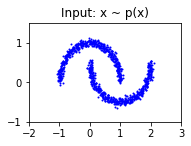

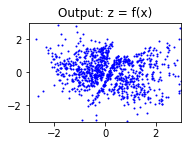

====> Test loss: -0.0592
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])


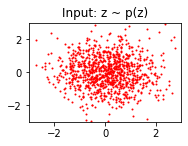

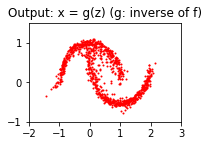

Train Epoch: 3 [0/50000 (0%)]	Loss: -0.057908
Train Epoch: 3 [6400/50000 (13%)]	Loss: -0.058695
Train Epoch: 3 [12800/50000 (26%)]	Loss: -0.058560
Train Epoch: 3 [19200/50000 (38%)]	Loss: -0.058379
Train Epoch: 3 [25600/50000 (51%)]	Loss: -0.058587
Train Epoch: 3 [32000/50000 (64%)]	Loss: -0.058916
Train Epoch: 3 [38400/50000 (77%)]	Loss: -0.057686
Train Epoch: 3 [44800/50000 (90%)]	Loss: -0.058871
====> Epoch: 3 Average train loss: -0.0585


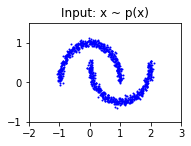

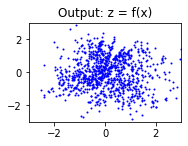

====> Test loss: -0.0602
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])


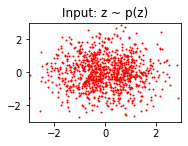

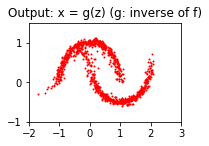

Train Epoch: 4 [0/50000 (0%)]	Loss: -0.058118
Train Epoch: 4 [6400/50000 (13%)]	Loss: -0.058607
Train Epoch: 4 [12800/50000 (26%)]	Loss: -0.059162
Train Epoch: 4 [19200/50000 (38%)]	Loss: -0.059511
Train Epoch: 4 [25600/50000 (51%)]	Loss: -0.059121
Train Epoch: 4 [32000/50000 (64%)]	Loss: -0.059531
Train Epoch: 4 [38400/50000 (77%)]	Loss: -0.059203
Train Epoch: 4 [44800/50000 (90%)]	Loss: -0.059077
====> Epoch: 4 Average train loss: -0.0591


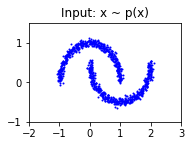

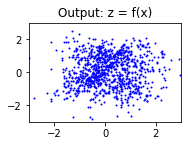

====> Test loss: -0.0605
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])


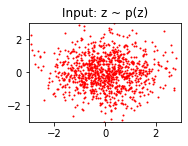

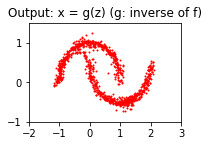

Train Epoch: 5 [0/50000 (0%)]	Loss: -0.059506
Train Epoch: 5 [6400/50000 (13%)]	Loss: -0.059661
Train Epoch: 5 [12800/50000 (26%)]	Loss: -0.059013
Train Epoch: 5 [19200/50000 (38%)]	Loss: -0.058927
Train Epoch: 5 [25600/50000 (51%)]	Loss: -0.059875
Train Epoch: 5 [32000/50000 (64%)]	Loss: -0.058717
Train Epoch: 5 [38400/50000 (77%)]	Loss: -0.058307
Train Epoch: 5 [44800/50000 (90%)]	Loss: -0.059817
====> Epoch: 5 Average train loss: -0.0593


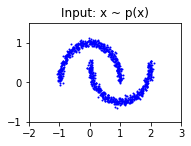

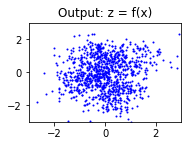

====> Test loss: -0.0605
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])


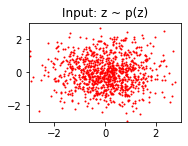

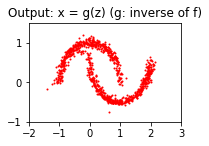

Train Epoch: 6 [0/50000 (0%)]	Loss: -0.059518
Train Epoch: 6 [6400/50000 (13%)]	Loss: -0.059750
Train Epoch: 6 [12800/50000 (26%)]	Loss: -0.060464
Train Epoch: 6 [19200/50000 (38%)]	Loss: -0.059538
Train Epoch: 6 [25600/50000 (51%)]	Loss: -0.059594
Train Epoch: 6 [32000/50000 (64%)]	Loss: -0.058000
Train Epoch: 6 [38400/50000 (77%)]	Loss: -0.059268
Train Epoch: 6 [44800/50000 (90%)]	Loss: -0.060064
====> Epoch: 6 Average train loss: -0.0594


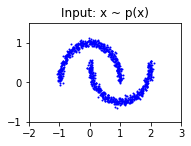

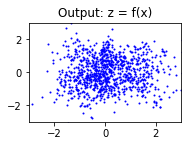

====> Test loss: -0.0607
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])


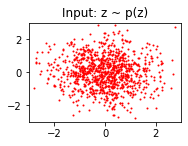

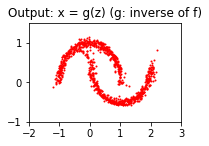

Train Epoch: 7 [0/50000 (0%)]	Loss: -0.059314
Train Epoch: 7 [6400/50000 (13%)]	Loss: -0.058849
Train Epoch: 7 [12800/50000 (26%)]	Loss: -0.059835
Train Epoch: 7 [19200/50000 (38%)]	Loss: -0.059267
Train Epoch: 7 [25600/50000 (51%)]	Loss: -0.058808
Train Epoch: 7 [32000/50000 (64%)]	Loss: -0.060007
Train Epoch: 7 [38400/50000 (77%)]	Loss: -0.058649
Train Epoch: 7 [44800/50000 (90%)]	Loss: -0.059838
====> Epoch: 7 Average train loss: -0.0595


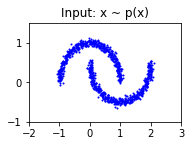

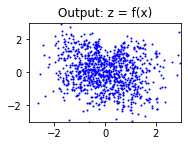

====> Test loss: -0.0608
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])


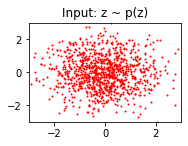

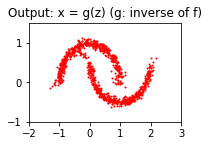

Train Epoch: 8 [0/50000 (0%)]	Loss: -0.059275
Train Epoch: 8 [6400/50000 (13%)]	Loss: -0.059322
Train Epoch: 8 [12800/50000 (26%)]	Loss: -0.059599
Train Epoch: 8 [19200/50000 (38%)]	Loss: -0.060028
Train Epoch: 8 [25600/50000 (51%)]	Loss: -0.060065
Train Epoch: 8 [32000/50000 (64%)]	Loss: -0.059522
Train Epoch: 8 [38400/50000 (77%)]	Loss: -0.060313
Train Epoch: 8 [44800/50000 (90%)]	Loss: -0.059670
====> Epoch: 8 Average train loss: -0.0595


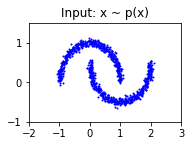

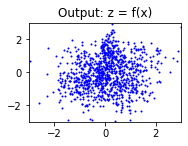

====> Test loss: -0.0606
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])


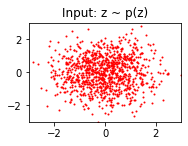

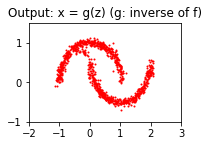

Train Epoch: 9 [0/50000 (0%)]	Loss: -0.059260
Train Epoch: 9 [6400/50000 (13%)]	Loss: -0.059827
Train Epoch: 9 [12800/50000 (26%)]	Loss: -0.059497
Train Epoch: 9 [19200/50000 (38%)]	Loss: -0.059209
Train Epoch: 9 [25600/50000 (51%)]	Loss: -0.059777
Train Epoch: 9 [32000/50000 (64%)]	Loss: -0.059559
Train Epoch: 9 [38400/50000 (77%)]	Loss: -0.059591
Train Epoch: 9 [44800/50000 (90%)]	Loss: -0.060966
====> Epoch: 9 Average train loss: -0.0595


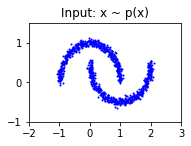

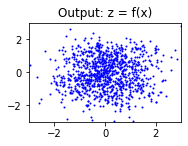

====> Test loss: -0.0611
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])


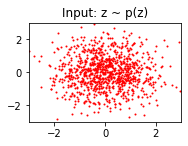

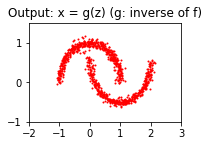

Train Epoch: 10 [0/50000 (0%)]	Loss: -0.060002
Train Epoch: 10 [6400/50000 (13%)]	Loss: -0.059574
Train Epoch: 10 [12800/50000 (26%)]	Loss: -0.060231
Train Epoch: 10 [19200/50000 (38%)]	Loss: -0.059254
Train Epoch: 10 [25600/50000 (51%)]	Loss: -0.059278
Train Epoch: 10 [32000/50000 (64%)]	Loss: -0.060138
Train Epoch: 10 [38400/50000 (77%)]	Loss: -0.060139
Train Epoch: 10 [44800/50000 (90%)]	Loss: -0.059670
====> Epoch: 10 Average train loss: -0.0596


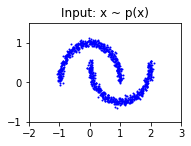

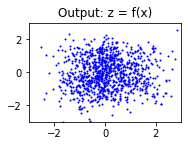

====> Test loss: -0.0610
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])
....................... YOOOO
torch.Size([2])


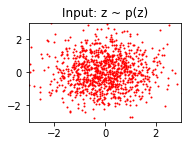

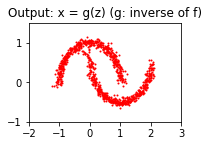

'177.72s'

<Figure size 432x288 with 0 Axes>

In [ ]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q20: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs and Normalizing flows?**

> The main advantadge of GANs is that they can generate good quality images that are very similar to the inputs. However, they are tricky to train, as we've seen we can easily have vanishing gradients due to having a successful discriminator ealy in the training. We also need a network that isn't too shallow to capture the complexity of the data, thus the need for careful hyperparameter tuning.